In [1]:
import sys
sys.path.append('..')

import numpy as np
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
import glob
import seaborn as sns

from model import *
from utils import *
import pandas as pd

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
def load_model(model, exp_name, ckpt=0, final=False, best=False, file_name=None):
    if file_name:
        fn = file_name
    elif best:
        fn = 'best-model.pth'
    elif final:
        fn = 'final-model.pth'
    else:
        fn = f'checkpoint-{ckpt}.pth'
    model_path = f'/mnt/cfs/sihaozhe/ss-dfd/exp/{exp_name}/model/{fn}'
    model_dict = torch.load(model_path)
    state_dict = model_dict['model']
    model.load_state_dict(state_dict)
    return model_dict['iter']

In [3]:
def dpt_post_op(dpt, post_op, near=0.1, far=10.):
    if post_op == 'clip':
        dpt = torch.clip(dpt, 0, 1).detach().cpu()
    elif post_op == 'norm':
        dpt_local_min = torch.min(dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
        dpt_local_max = torch.max(dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
        norm_dpt_ = dpt / (dpt_local_max + 1e-8)
        # norm_dpt_ = (dpt - dpt_local_min)/(dpt_local_max - dpt_local_min + 1e-8)
        norm_dpt = norm_dpt_ * (far - near) + near
        dpt = norm_dpt.detach().cpu()
    return dpt

In [4]:
data_path = '/mnt/cfs/sihaozhe/data/sc-ds/07'
split = 'train'
device = 5
use_cuda = True

In [5]:
cam_far = 3
dataset_config = {
    'root_dir': data_path,
    'shuffle': False,
    'img_num':  5, 
    'visible_img': 5,
    'focus_dist': [0.52, 0.69, 0.87, 1.69, 2.3],
    'recon_all': True,
    'RGBFD': True,
    'near': 0.1,
    'far': cam_far,
    'scale':4,
}

In [6]:
dl, _, _ = load_data(dataset_config, 'SC', 1)

5 out of 5 images per sample are visible for input
Total number of sample: 1


In [7]:
torch.cuda.set_device(device)

In [8]:
# camera = ThinLenCamera(pixel_size=5.6e-6)
camera = ThinLenCamera(fnumber=5.6, focal_length=50*1e-3, pixel_size=6.5e-5)
render = GaussPSF(7)
render.cuda()
model = FUNet(4, 4)

In [9]:
dll = iter(dl)

In [10]:
sample = next(dll)

In [11]:
sample['rgb_fd'].shape

torch.Size([1, 5, 4, 912, 1360])

## Model Eval

In [12]:
ckpt = 1500
final = False
best = True
post_op = 'norm'
model_names = ['sc_07']
upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

In [13]:
exp_name = f'{model_names[0]}'
n_iter = load_model(model, exp_name, ckpt, best=best)
model = model.cuda()
for i, batch in enumerate(dl):
    with torch.no_grad():
        raw_aif_dpt = model(batch['rgb_fd'].cuda())
        raw_aif = raw_aif_dpt[:, :-1]
        raw_dpt = raw_aif_dpt[:, -1]
    pred_dpt = dpt_post_op(raw_dpt, post_op, far=cam_far)
    pred_dpt = upsample(pred_dpt.unsqueeze(0)).squeeze(0)
    pred_aif = torch.clip(raw_aif, 0, 1)

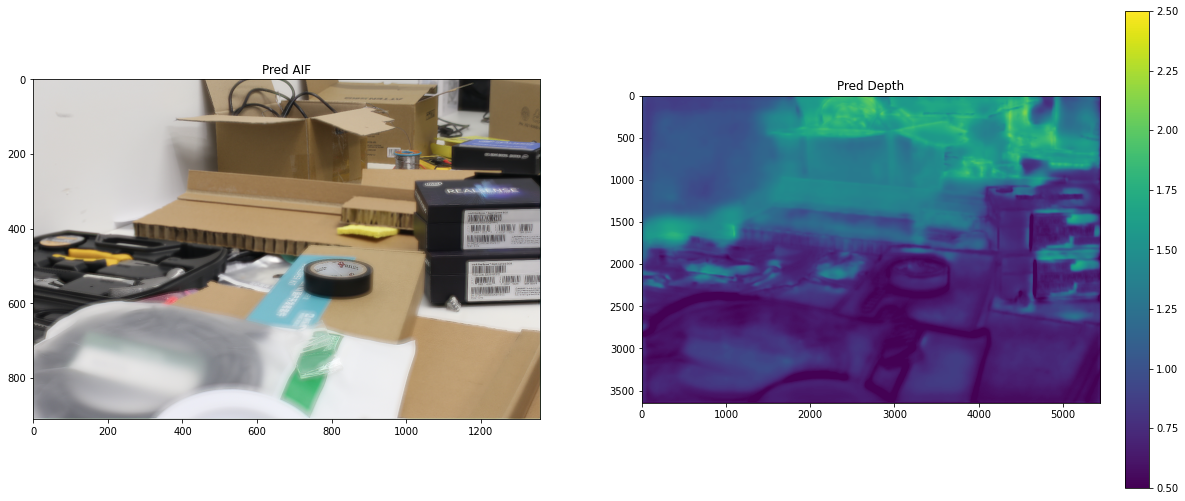

In [27]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Pred AIF')
plt.imshow(pred_aif[0].cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('Pred Depth')
plt.imshow(pred_dpt[0].cpu().numpy(), cmap='viridis')
plt.clim(0.5, 2.5) 
plt.colorbar(fraction=0.047)

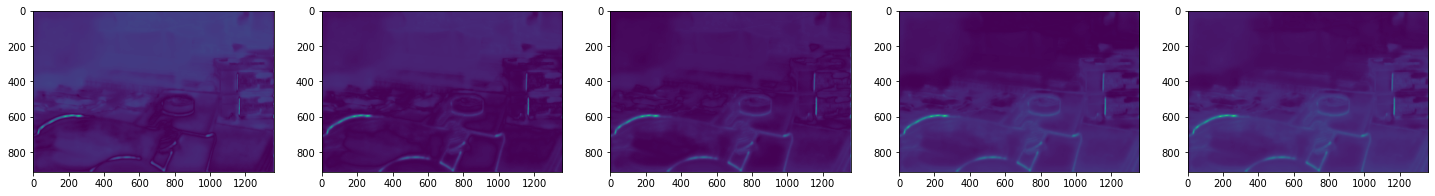

In [17]:
B, FS, C, H, W = batch['output'].shape
dpt = pred_dpt[:, ::4, ::4].expand(FS, H, W)
fd = batch['output_fd'].view(-1, 1, 1).expand_as(dpt)
defocus = camera.getCoC(dpt, fd).unsqueeze(1)
plt.figure(figsize=(25, 6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(defocus[i, 0].cpu().numpy())

In [18]:
inp_fs = batch['rgb_fd'][:, :, :-1]
clear_idx = torch.argmin(defocus.view(B, FS, 1, H, W).expand(B, FS, C, H, W), dim=1, keepdim=True)
coarse_aif = torch.gather(inp_fs, 1, clear_idx).squeeze(1)

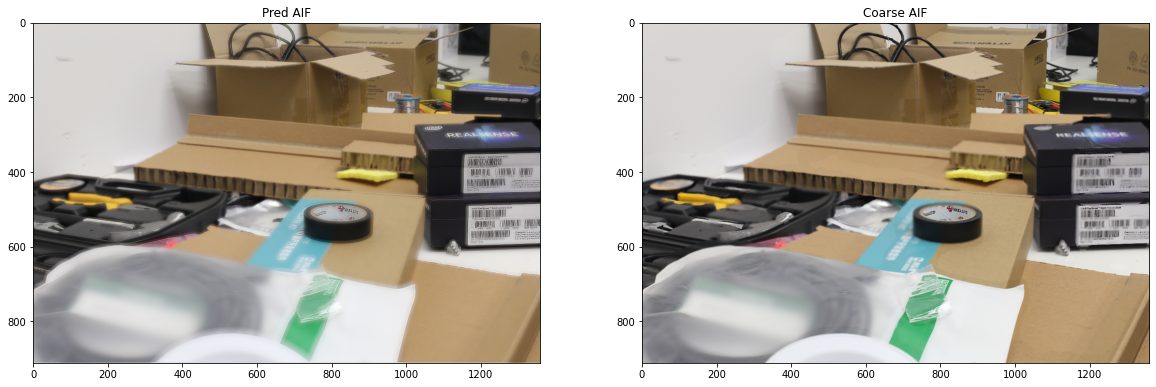

In [19]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Pred AIF')
plt.imshow(pred_aif[0].cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('Coarse AIF')
plt.imshow(coarse_aif[0].numpy().transpose(1, 2, 0))
# plt.savefig('NYU_orig_unsup_vis_aif.png', dpi=200)

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [ ]:
dpt = pred_dpt[0, ::10, ::10]
H, W = dpt.shape

In [ ]:
H, W

In [ ]:
x = np.arange(W)
y = np.arange(H)
X, Y = np.meshgrid(x, y)

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot_wireframe(Y, X, dpt)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(210, 130, 'x')